In [1]:
#from parse_kd import *
import re
import pandas as pd
import numpy as np
from chunk_utils import *
from sklearn.neighbors.kde import KernelDensity
import matplotlib
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
from pyclustering.cluster.xmeans import xmeans
from scipy.special import kl_div
data_dir = './data/dw_freetext/'

In [2]:
%load_ext autoreload
%autoreload 2
matplotlib.rcParams['figure.figsize'] = 8,5

In [3]:
df = pd.read_csv(data_dir+'GunControl_400.csv', delimiter='\t', usecols=[0,6,10])
df_filtered = df[df['Task']=='Copy_2']
# "Copy_2" column = when they're stating true opinion, repeating (transcribing) the essay already written
df_filtered.head(7)

,UserName,Task,ReviewMeta
1,A10E8QHPV30BAD,Copy_2,0 MouseUp 0 0;874 KeyDown 16;946 KeyDown 73;10...
5,A11T1LGIWPM9Z1,Copy_2,0 MouseUp 0 0;784 KeyDown 16;863 KeyDown 84;92...
9,A145PJ769UGAID,Copy_2,0 MouseUp 0 0;1517 KeyDown 16;1517 KeyDown 87;...
13,A161NZP385W1TX,Copy_2,0 MouseUp 0 0;1621 KeyDown 16;1734 KeyDown 84;...
17,A168RQT8B18FH,Copy_2,0 MouseUp 0 0;2112 KeyDown 16;2311 KeyDown 73;...
21,A16HFBY06FP1RJ,Copy_2,0 MouseUp 0 0;317 KeyDown 16;543 KeyDown 71;62...
25,A191P01GHJRPWO,Copy_2,0 MouseUp 0 0;7007 KeyDown 16;7018 KeyDown 73;...


amendment : 72


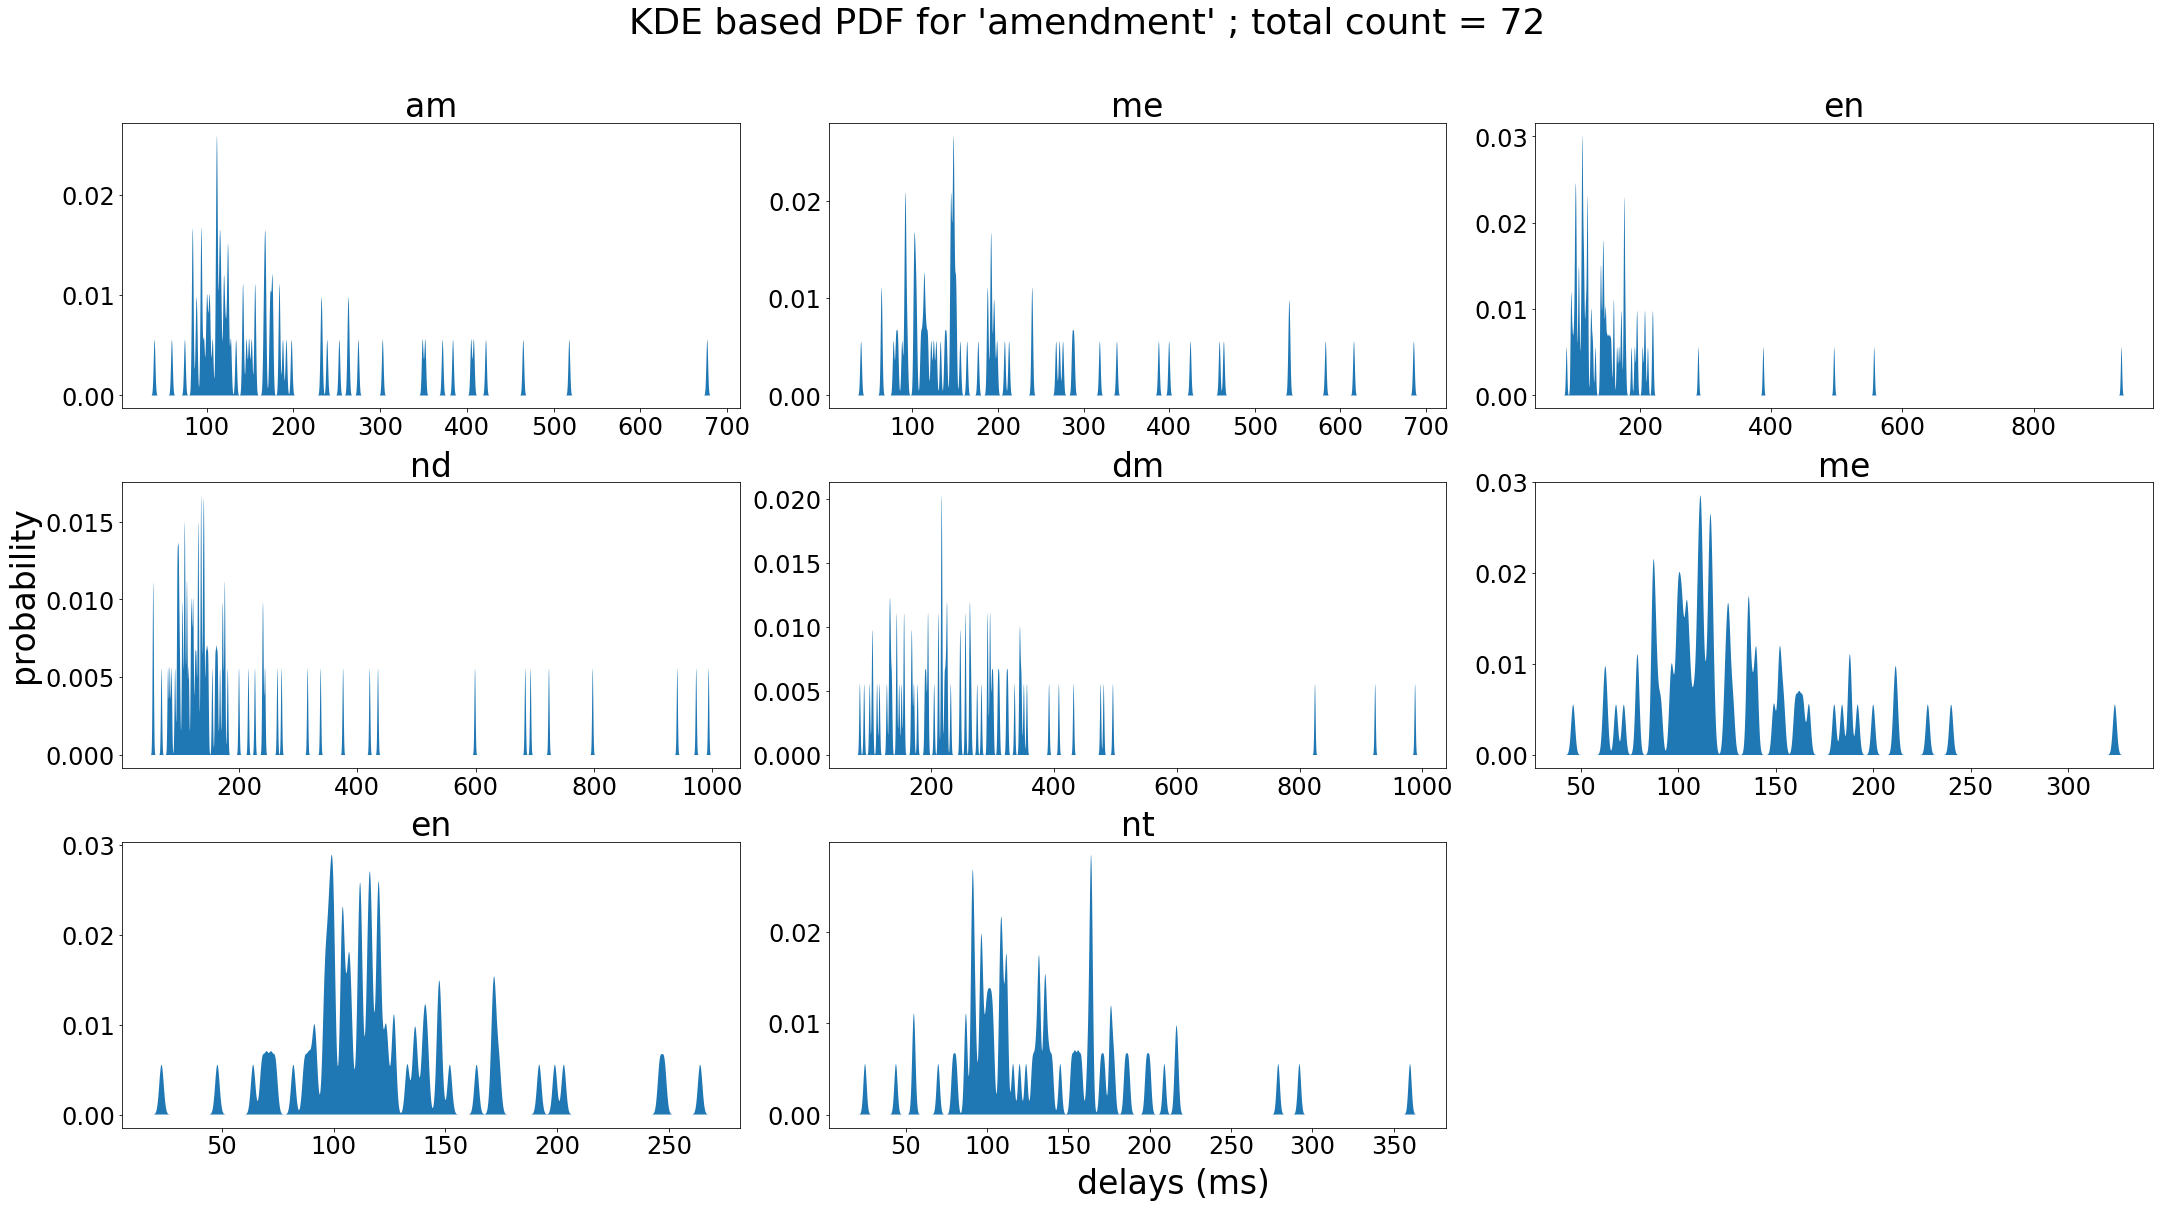

In [32]:
phrase = "amendment"

phrase_delays = []

for textIndex in range(df_filtered.shape[0]):
    rawkd = df_filtered['ReviewMeta'].iloc[textIndex]
    phrase_keys = get_phrases_from_rawkd(rawkd, phrase)    
    this_delays = [keypress2delays(phrase, k) for k in phrase_keys]
    
    phrase_delays.extend(this_delays)
    
    
phrase_delays = np.array(phrase_delays)
print ("{} : {}".format(phrase, len(phrase_delays)))


# ======================================

models = [KernelDensity() for  x in range(phrase_delays.shape[1])]
# for each keypair in the typed word..build a model
for i in range(phrase_delays.shape[1]):
    models[i].fit(phrase_delays[:,i].reshape(-1,1))
        
keypairs = list(map(lambda x: x[0]+x[1], zip(phrase, phrase[1:])))

typedname = phrase

# find the probability density function for a key pair
proba_values = []

matplotlib.rcParams['figure.figsize'] = 30,17
fig = plt.figure()
total_plts = len(typedname)-1
n_cols = 3
n_rows = int(np.ceil(total_plts/n_cols)) # want 4 columns, and as many rows as required

for keyIndex in range(len(phrase)-1):
    delayspace = np.linspace(10,1000,7000)
    logprobX = models[keyIndex].score_samples(delayspace.reshape(-1,1))
    prob = np.exp(logprobX)
    epsilon = 1e-8
    nonzero_indx = prob>=epsilon
    prob_nonzero = prob[nonzero_indx]
    delayspace = delayspace[nonzero_indx]
    
    ax1 = fig.add_subplot(n_rows,n_cols,keyIndex+1)
    ax1.fill(delayspace,prob_nonzero)
    ax1.set_title(keypairs[keyIndex], fontsize=33)
    ax1.tick_params(axis='both', which='major', labelsize=24)
    

plt.subplots_adjust(wspace=0.9, hspace=2.8)
fig.text(0.54, 0.01, 'delays (ms)', ha='center', fontsize=33)
fig.text(0, 0.5, 'probability', va='center', rotation='vertical', fontsize=33)
plt.suptitle("KDE based PDF for '{}' ; total count = {}".format(typedname, len(phrase_delays)),fontsize=36)
plt.tight_layout(rect=[0.02, 0.03, 1, 0.92])
plt.savefig('guncontrol__' + phrase + '_kde_subplots.png',format='png')
plt.show()

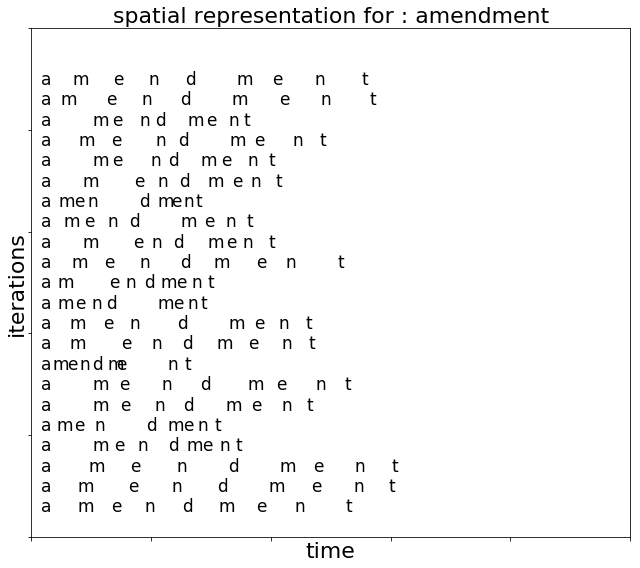

In [34]:
ypos = 0.01
ydelta = 0.04

typedname_ = phrase
raw_delays = phrase_delays[:22]
# cannot plot more than 20 ish rows

matplotlib.rcParams['figure.figsize'] = 9,8

for dd in raw_delays:
    xposvector = get_xpos_from_delays(dd, space_min = 0.016, max_delta_spacing=0.07)
    for char, xpos in zip(typedname_, xposvector):
        plt.text(xpos, ypos + ydelta, char, fontsize=17)
    ypos += ydelta

plt.title('spatial representation for : '+typedname_, fontsize=22)
plt.xlabel('time', fontsize=22)
plt.ylabel('iterations', fontsize=22)
plt.tick_params(axis='both', labelbottom=False, labelleft=False) 
plt.tight_layout()
plt.savefig('guncontrol__spatialrep__' + phrase + '.png', format='png')